In [29]:
# Import Required Packages
import torch
import torchvision
from torchvision import transforms
from pycocotools.coco import COCO
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import fiftyone.zoo as foz
from torchvision.io.image import read_image
from torchvision.ops import deform_conv2d
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.optim import Adam
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor
import torchvision.ops
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [19]:
class DeformableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
        super(DeformableConv2d, self).__init__()
        self.padding = padding

        # Offset convolution layer to learn the offsets of the sampling locations
        self.offset_conv = nn.Conv2d(in_channels, 2 * kernel_size * kernel_size, kernel_size=kernel_size, stride=stride, padding=self.padding, bias=True)

        # Initialize weights and bias of offset convolution to 0
        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        # Modulator convolution layer to learn the modulation scalars of the sampling locations
        self.modulator_conv = nn.Conv2d(in_channels, 1 * kernel_size * kernel_size, kernel_size=kernel_size, stride=stride, padding=self.padding, bias=True)

        # Initialize weights and bias of modulator convolution to 0
        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        # Regular convolution layer
        self.regular_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=self.padding, bias=bias)

    def forward(self, x):
        h, w = x.shape[2:]  # Height and width of the input
        max_offset = max(h, w)/4.

        # Compute offset and clamp it within the range [-max_offset, max_offset]
        offset = self.offset_conv(x).clamp(-max_offset, max_offset)

        # Compute modulator and apply sigmoid function scaled by 2
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))

        # Apply deformable convolution
        x = torchvision.ops.deform_conv2d(input=x, offset=offset, weight=self.regular_conv.weight, bias=self.regular_conv.bias, padding=self.padding, mask=modulator)

        return x


In [34]:
# Define the CNN model
class MyCNN(nn.Module):
    def __init__(self, classes):
        super(MyCNN, self).__init__()

        # First convolutional layer with 3 input channels and 32 output channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=True)
        # Second convolutional layer with 32 input channels and 32 output channels
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        # Third convolutional layer with 32 input channels and 32 output channels
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        # Fourth convolutional layer, a deformable convolutional layer
        self.conv4 = DeformableConv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        # Fifth convolutional layer, a deformable convolutional layer
        self.conv5 = DeformableConv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        # Max pooling layer with a kernel size of 2
        self.pool = nn.MaxPool2d(2)
        # Global average pooling layer to reduce each channel to a single value
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer with an output size equal to the number of classes
        self.fc = nn.Linear(32, len(classes))

    def forward(self, x):
          # Apply the first convolutional layer followed by ReLU activation function
          x = torch.relu(self.conv1(x))
          # Apply max pooling
          x = self.pool(x) # [112, 112]
          # Apply the second convolutional layer followed by ReLU activation function
          x = torch.relu(self.conv2(x))
          # Apply max pooling
          x = self.pool(x) # [56, 56]
          # Apply the third, fourth, and fifth convolutional layers followed by ReLU activation function
          x = torch.relu(self.conv3(x))
          x = torch.relu(self.conv4(x))
          x = torch.relu(self.conv5(x))
          # Apply global average pooling
          x = self.gap(x)
          # Flatten the tensor from the second dimension
          x = x.flatten(start_dim=1)
          # Apply the fully connected layer
          x = self.fc(x)
          return x

In [21]:
class COCO(Dataset):
    def __init__(self, datasets, classes, transforms=None):
        # Initialize the dataset, classes, and transforms
        self.dataset = datasets
        self.classes = classes
        self.transform = transforms

    def __len__(self):
        # Return the length of the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get a sample from the dataset
        sample = self.dataset[idx]
        # Open the image file associated with the sample and convert it to RGB
        image = Image.open(sample.filepath).convert('RGB')

        # Initialize the label to a zero vector
        label = np.zeros(len(self.classes), dtype=np.float32)

        # Assign 1 to the positions of the classes present in the image
        for detection in sample.ground_truth.detections:
            if detection.label in classes:
                label[classes.index(detection.label)] = 1.0
        # Apply the transforms to the image
        image = self.transform(image)

        # Convert the label to a PyTorch tensor
        label = torch.tensor(label, dtype=torch.float64)

        # Return the transformed image and the label
        return image, label

In [22]:
# Define the classes for which we want to load the data
classes = ['bicycle', 'car', 'cat', 'chair', 'cow', 'dog', 'horse', 'person', 'sheep']

# Load the training dataset from the COCO 2017 dataset in the FiftyOne Dataset Zoo
# The data includes segmentations labels
dataset_train = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["segmentations"],
    classes=classes,
    max_samples=20000,
)
# Convert the dataset to a list for further processing
dataset_train = list(dataset_train)

# Similarly, load the validation dataset from the COCO 2017 dataset in the FiftyOne Dataset Zoo
# The data includes segmentations labels
dataset_test = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["segmentations"],
    classes=classes,
    max_samples=2000,
)
# Convert the dataset to a list for further processing
dataset_test = list(dataset_test)

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading existing dataset 'coco-2017-train-20000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'coco-2017-train-20000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'validation' is sufficient


Loading existing dataset 'coco-2017-validation-2000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'coco-2017-validation-2000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [23]:
# Check if CUDA is available and set the device to GPU if it is, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the transformations to be applied on the images
# Resize the images to 224x224, convert them to tensors, and normalize them
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create a COCO dataset for the training data
# Apply the defined transformations on the dataset
trainset = COCO(datasets=dataset_train, classes=classes, transforms=transforms)

# Create a DataLoader for the training dataset
# Set the batch size to 128 and shuffle the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# Similarly, create a COCO dataset for the test data and apply the transformations
testset = COCO(datasets=dataset_test, classes=classes, transforms=transforms)

# Create a DataLoader for the test dataset
# Set the batch size to 32 and do not shuffle the data
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


Epoch 1/5:
Training Loss: 0.2879
Total Accuracy: 90.02%
Per Class Accuracy: [95.41699981689453, 81.74761199951172, 94.87957763671875, 82.82245635986328, 94.62579345703125, 92.62042236328125, 91.4311294555664, 78.39370727539062, 98.25338745117188]
Epoch 2/5:
Training Loss: 0.2514
Total Accuracy: 91.77%
Per Class Accuracy: [96.07882690429688, 84.69347381591797, 94.81986999511719, 84.19088745117188, 97.53185272216797, 94.62579345703125, 96.29776763916016, 79.46357727050781, 98.23845672607422]
Epoch 3/5:
Training Loss: 0.2474
Total Accuracy: 91.76%
Per Class Accuracy: [96.0340347290039, 84.57404327392578, 94.8945083618164, 84.22074127197266, 97.53185272216797, 94.58101654052734, 96.31269836425781, 79.47850036621094, 98.25338745117188]
Epoch 4/5:
Training Loss: 0.2450
Total Accuracy: 91.76%
Per Class Accuracy: [96.0340347290039, 84.58399963378906, 94.87957763671875, 84.17595672607422, 97.53185272216797, 94.56608581542969, 96.29776763916016, 79.48348236083984, 98.25338745117188]
Epoch 5/5:
T

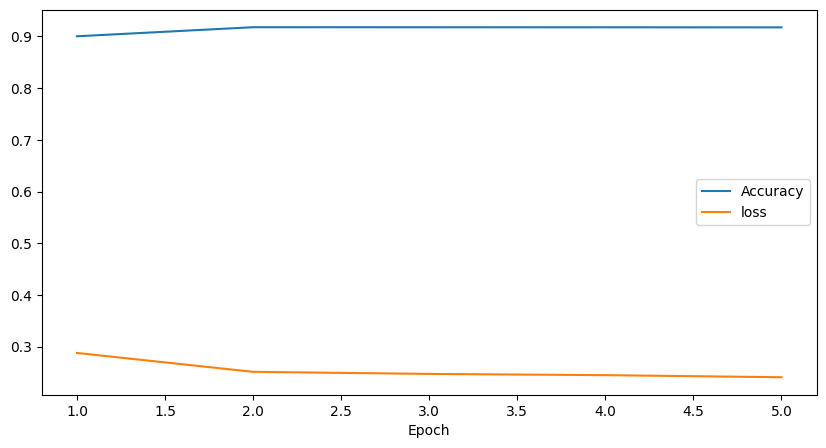

In [36]:
# Instantiate the model
model = MyCNN(classes).to(device)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Set the number of training epochs
epochs = 5

# Initialize lists to store accuracy and loss values for each epoch
accuracy_values = []
loss_values = []

# Start the training loop
for epoch in range(epochs):

    running_loss = 0.0
    overall_accuracy = 0
    accuracy_per_label = torch.zeros(len(classes), device=device)

    # Iterate over the training data
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Apply sigmoid function and threshold at 0.5 to get predictions
        preds = torch.sigmoid(outputs) > 0.5

        # Calculate the correct predictions
        correct_predictions = (preds == labels).float()

        # Calculate the accuracy for each label
        accuracy_per_label += correct_predictions.sum(0)/(len(labels))

        # Calculate the overall accuracy
        overall_accuracy += correct_predictions.sum()/(len(labels)*(len(classes)))

    # Calculate the average accuracy for each label
    accuracy_per_label /= len(trainloader)

    # Calculate the average loss
    running_loss /= len(trainloader)

    # Calculate the overall average accuracy
    overall_accuracy /= len(trainloader)

    # Store accuracy and loss values
    accuracy_values.append(overall_accuracy.item())
    loss_values.append(running_loss)

    # Print training statistics after each epoch
    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Training Loss: {running_loss:.4f}')
    print(f'Total Accuracy: {overall_accuracy*100:.2f}%')
    print('Per Class Accuracy:', (accuracy_per_label*100).tolist())

# Plot accuracy per epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), accuracy_values, label='Accuracy')
plt.plot(range(1, epochs+1), loss_values, label='loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [37]:
# Testing the model
with torch.no_grad():

    overall_accuracy = 0
    accuracy_per_label = torch.zeros(len(classes), device=device)

    # Iterate over the test data
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # Forward pass
        outputs = model(images)

        # Apply sigmoid function and threshold at 0.5 to get predictions
        preds = torch.sigmoid(outputs) > 0.5

        # Calculate the correct predictions
        correct_predictions = (preds == labels).float()

        # Calculate the accuracy for each label
        accuracy_per_label += correct_predictions.sum(0)/(len(labels))

        # Calculate the overall accuracy
        overall_accuracy += correct_predictions.sum()/(len(labels)*(len(classes)))

    # Calculate the average accuracy for each label
    accuracy_per_label /= len(testloader)

    # Calculate the overall average accuracy
    overall_accuracy /= len(testloader)

    # Print testing statistics
    print(f'Total Accuracy: {overall_accuracy*100:.2f}%')
    print('Per Class Accuracy:', (accuracy_per_label*100).tolist())

Total Accuracy: 91.34%
Per Class Accuracy: [95.23809814453125, 84.52381134033203, 94.39484405517578, 82.93651580810547, 97.37103271484375, 94.74207305908203, 96.08135223388672, 78.5714340209961, 98.16468811035156]
